In [1]:
%matplotlib inline
import matplotlib
matplotlib.rc('font', family='arial') 
import matplotlib.pyplot as plt
import numpy as np
import flika as flk
from skimage.exposure import rescale_intensity as rescale
from moviepy.editor import ImageSequenceClip, VideoClip, concatenate_videoclips
from moviepy.video.io.bindings import mplfig_to_npimage
from matplotlib.patches import Rectangle
from scipy.interpolate import interp1d
import czifile as czi
flk.start_flika()

Starting flika


Starting flika inside IPython


In [2]:
fname = '/nrs/ahrens/Yu/expansion/large tile.czi'
# lateral extent of the field of view, in microns
fov = 1100
data_r = czi.imread(fname).squeeze().astype('float32')
bg = data_r.min(1)
data_r = (data_r.transpose(1,0,2,3) - bg).transpose(1,0,2,3)
# channel 0 is NE, 1 is glia
data_c = np.zeros([*data_r.shape[1:], 3], dtype='float32')

# rescale the data and make RGB 
ne_in_range = (10,300)
g_in_range=(10,8000)
data_c[:,:,:,0] = rescale(data_r[0].astype('float32'), in_range=ne_in_range, out_range=(0,1))
data_c[:,:,:,1] = rescale(data_r[1].astype('float32'), in_range=g_in_range, out_range=(0,1))
data_c[:,:,:,2] = rescale(data_r[0].astype('float32'), in_range=ne_in_range, out_range=(0,1))

In [3]:
fps = 24
figsize = (8, 4.5)
fd_small = {'fontsize' : 8, 'color' : 'w'}

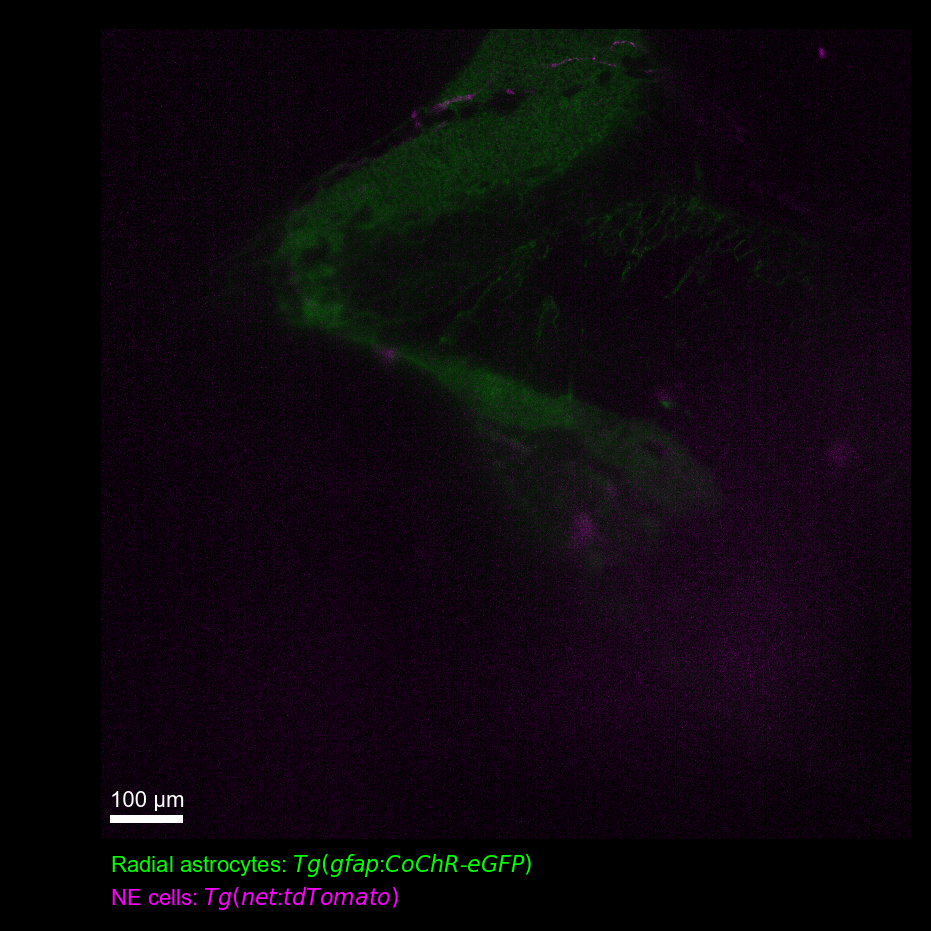

In [4]:
plr = slice(15, 320)
data_dur = 10
interper = interp1d(x=np.linspace(0, data_dur, len(data_c[plr])), y=data_c[plr], axis=0, bounds_error='extrapolate')

fig, axs = plt.subplots(dpi=200, figsize=figsize, facecolor='k')
axs.set_facecolor('k')
axs.axis('off')
axs.set_position([.1,.1,.9,.9])

#length of scale bar, in microns
scale_bar_length = 100

scale_label = dict(x = .01, y=.04, s='100 µm', transform=axs.transAxes, fontdict=dict(color=(1,1,1), size=8))
scale_bar = Rectangle((.01,.02), scale_bar_length/fov, .01, transform = axs.transAxes, facecolor='w')

tdt_label = dict(x = .01, y=-.08, s='NE cells: $\it{Tg(net}$:$\it{tdTomato)}$', transform=axs.transAxes, fontdict=dict(color=(1,0,1), size=8))
gcamp_label = dict(x = .01, y=-.04, s='Radial astrocytes: $\it{Tg(gfap}$:$\it{CoChR}$-$\it{eGFP)}$', transform=axs.transAxes, fontdict=dict(color=(0,1,0), size=8))

axs.add_patch(scale_bar)
axs.text(**scale_label)
axs.text(**tdt_label)
axs.text(**gcamp_label)
axs.imshow(interper(0))

def draw_frame(t_):
    axs.images[0].set_data(interper(t_))
    return mplfig_to_npimage(fig)

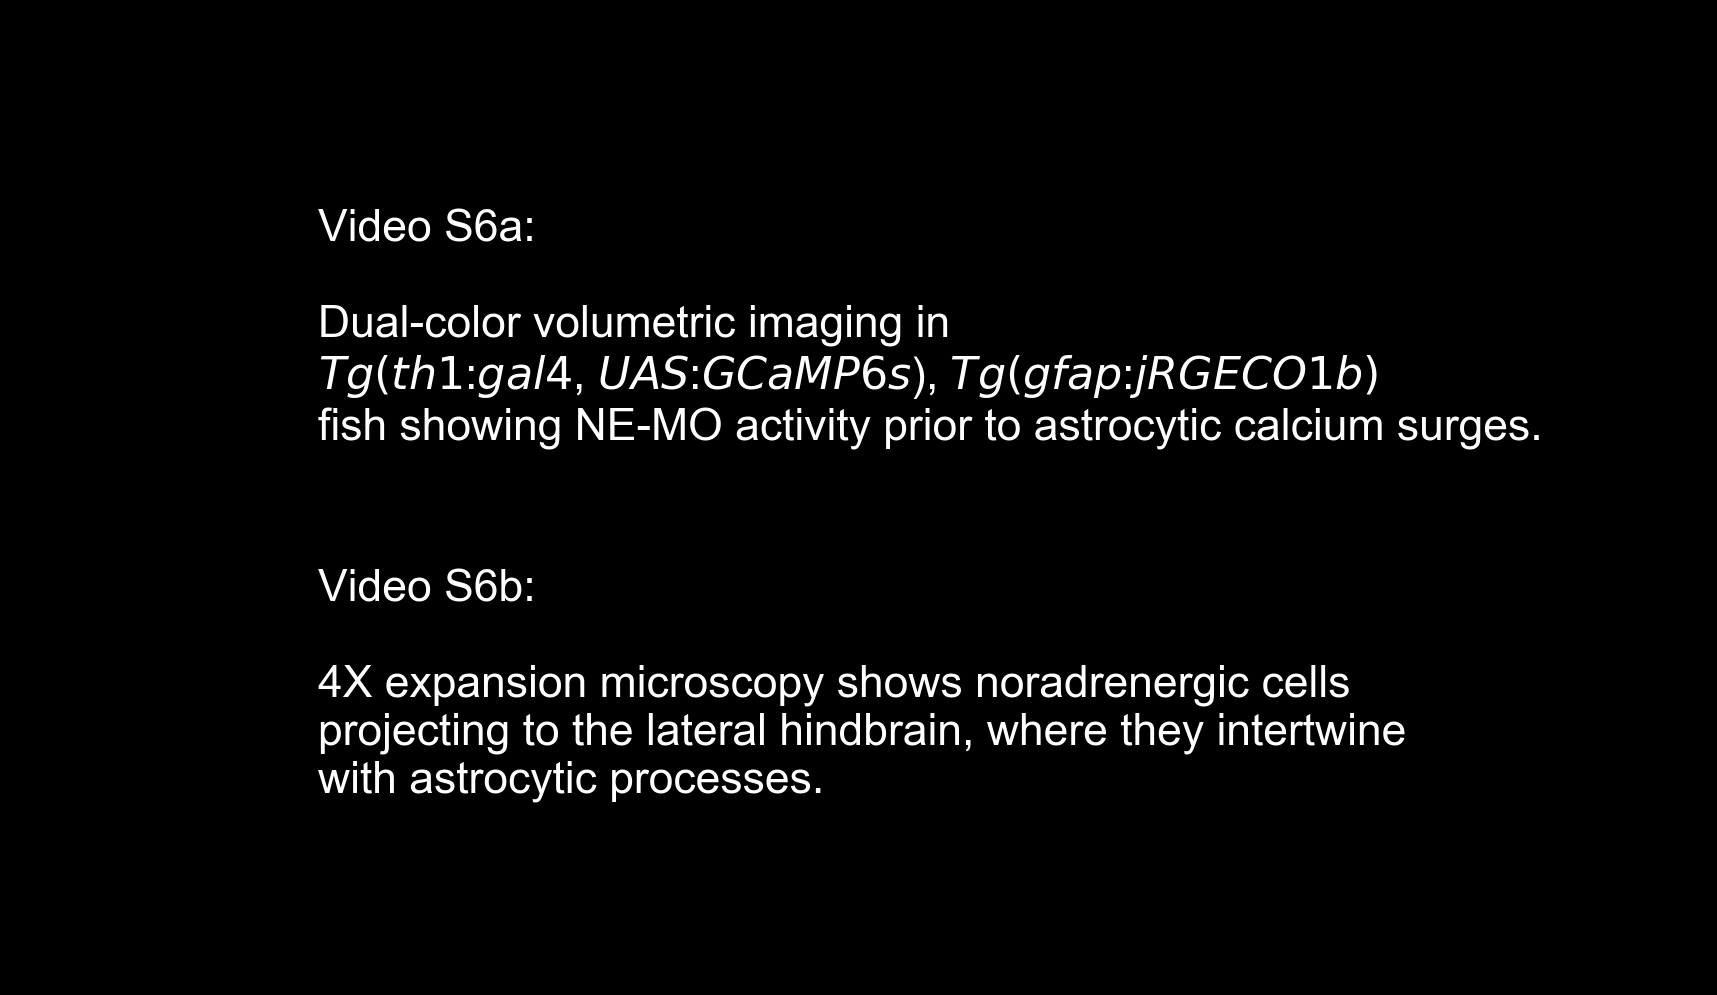

In [5]:
## make the title card 
title_dur = 4
fig_intro = plt.figure(dpi=200, figsize=np.array(figsize), facecolor='k')
ax_intro = fig_intro.add_axes((0,0,1,1))
ax_intro.set_facecolor('k')

s8a_intro_text =r'''Video S6a:

Dual-color volumetric imaging in 
$\it{Tg(th1}$:$\it{gal4}$, $\it{UAS}$:$\it{GCaMP6s}$), $\it{Tg(gfap}$:$\it{jRGECO1b)}$
fish showing NE-MO activity prior to astrocytic calcium surges.   
'''

s8b_intro_text =r'''Video S6b:

4X expansion microscopy shows noradrenergic cells 
projecting to the lateral hindbrain, where they intertwine 
with astrocytic processes.                         
'''

color_fade = interp1d([0,1,2,3], [1,.75,.5,.5], fill_value='extrapolate')
            
s8a_intro = ax_intro.text(.15,
                  .8,
                  s8a_intro_text, 
                  fontdict=dict(color='w', size=16), 
                  transform=ax_intro.transAxes, 
                  ha = 'left',
                  va='top',
                  multialignment='left')

s8b_intro = ax_intro.text(.15,
                  .4,
                  s8b_intro_text, 
                  fontdict=dict(color='w', size=16), 
                  transform=ax_intro.transAxes, 
                  ha = 'left',
                  va='top',
                  multialignment='left')

def drawf_intro(t_):
    s8a_intro.set_color(3 * [0 + color_fade(t_)])
    return mplfig_to_npimage(fig_intro)

title_clip = VideoClip(drawf_intro, duration=title_dur)

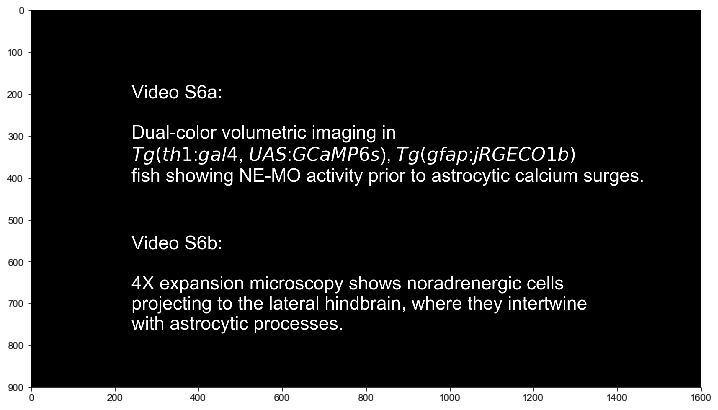

In [6]:
_,_  = plt.subplots(figsize=(12,12))
plt.imshow(drawf_intro(0))

In [7]:
data_clip = VideoClip(draw_frame, duration=data_dur)

codec = 'h264'
vid_fname = f'/groups/ahrens/ahrenslab/projects/ngm/presentation/movies/Video_S6b.mp4'
ind = 0 

composite_clip = concatenate_videoclips([title_clip, data_clip])
composite_clip.write_videofile(vid_fname, audio=False, codec=codec, fps=fps, ffmpeg_params=['-pix_fmt', 'yuv420p'])

Moviepy - Building video /groups/ahrens/ahrenslab/projects/ngm/presentation/movies/Video_S6b.mp4.
Moviepy - Writing video /groups/ahrens/ahrenslab/projects/ngm/presentation/movies/Video_S6b.mp4



Moviepy - Done !
Moviepy - video ready /groups/ahrens/ahrenslab/projects/ngm/presentation/movies/Video_S6b.mp4
